In [1]:
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=False)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 3702
Number of labels found: 3702
Number of unique characters: 1885
Characters present: {'㐌': 387, '浪': 359, '朱': 296, '\U000f070b': 292, '𠊛': 262, '\U000f047c': 260, '尼': 256, '娘': 252, '𦋦': 248, '𢚸': 246, '吏': 236, '固': 231, '拱': 220, '之': 199, '埃': 195, '情': 194, '𠳒': 179, '買': 178, '群': 175, '芇': 173, '𠓨': 157, '欺': 154, '別': 149, '麻': 148, '花': 147, '𠬠': 146, '𧗱': 144, '爫': 143, '仙': 142, '𡗶': 138, '𠄩': 132, '塘': 129, '如': 127, '𦖑': 126, '浽': 123, '𠫾': 122, '命': 122, '時': 121, '渚': 120, '渃': 118, '饒': 116, '呐': 115, '払': 115, '強': 114, '分': 114, '傷': 109, '𡢐': 108, '些': 108, '冲': 107, '鐄': 106, '𫽄': 106, '𢬣': 104, '低': 104, '生': 102, '皮': 100, '於': 100, '𧡊': 99, '仍': 99, '身': 98, '咍': 98, '茹': 97, '庒': 95, '牢': 94, '𣈜': 94, '昆': 93, '調': 92, '沛': 89, '\U000f061a': 89, '緣': 88, '細': 87, '公': 86, '月': 85, '油': 84, '﨤': 84, '戈': 84, '典': 84, '爲': 83, '排': 81, '畧': 80, '催': 78, '㗂': 77, '包': 76, '碎': 75, '𠁀': 75, '\U000f02c7': 74, '貝': 70, '賒': 70, '𢪀': 69, '共'

## Visualize the data

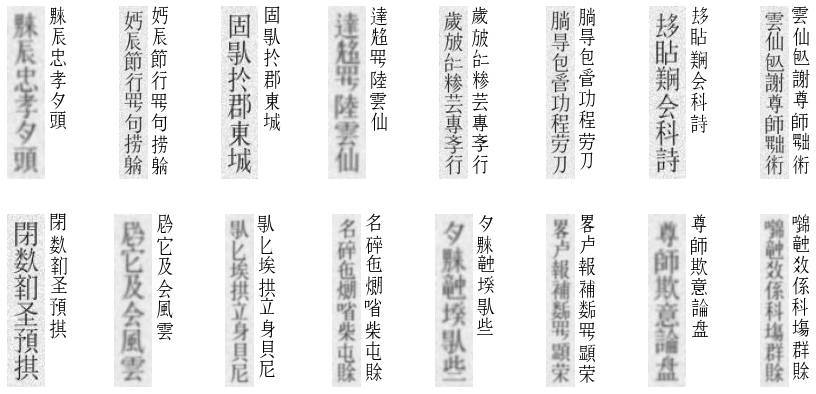

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, GRU,
    Lambda, RepeatVector, Permute, multiply
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_weights')(a)
    
    # Calculate the average of all timesteps and multiply by 100 to convert
    # the fraction obtained from the softmax calculation into a percentage
    a = Lambda(
        lambda x: tf.keras.backend.mean(x, axis=1) * 100, 
        name = 'average_weight'
    )(a)
    
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='attention_vector')(a) 
    return multiply([feature_maps, a], name='context_vector') 

In [10]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN and apply attention mechanism
    x = reshape_for_cnn(x, dim_to_keep=-1)
    x = visual_attention(x)
    
    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.4,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [11]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [12]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

                                                                    'rnn_output[0][0]',             
                                                                    'label_length[0][0]']           
                                                                                                    
Total params: 15,368,849
Trainable params: 15,364,369
Non-trainable params: 4,480
____________________________________________________________________________________________________


# Training

In [13]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [14]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [15]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    min_lr = 1e-7, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [17]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [18]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [19]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
209/209 [==============================] - 16s 45ms/step - loss: 51.1317 - val_loss: 53.3158 - lr: 2.0000e-04
Epoch 2/100
209/209 [==============================] - 7s 32ms/step - loss: 46.2278 - val_loss: 49.9302 - lr: 2.0000e-04
Epoch 3/100
209/209 [==============================] - 7s 32ms/step - loss: 41.5146 - val_loss: 44.8140 - lr: 2.0000e-04
Epoch 4/100
209/209 [==============================] - 7s 33ms/step - loss: 27.0186 - val_loss: 23.0740 - lr: 2.0000e-04
Epoch 5/100
209/209 [==============================] - 7s 33ms/step - loss: 15.9549 - val_loss: 15.2198 - lr: 2.0000e-04
Epoch 6/100
209/209 [==============================] - 10s 50ms/step - loss: 9.7312 - val_loss: 10.9171 - lr: 2.0000e-04
Epoch 7/100
209/209 [==============================] - 7s 34ms/step - loss: 6.0450 - val_loss: 9.7518 - lr: 2.0000e-04
Epoch 8/100
209/209 [==============================] - 10s 33ms/step - loss: 3.7816 - val_loss: 6.7315 - lr

Epoch 37/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0327 - val_loss: 2.3859 - lr: 1.2500e-05
Epoch 38/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0321 - val_loss: 2.3939 - lr: 1.2500e-05
Epoch 39/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0316 - val_loss: 2.3685 - lr: 1.2500e-05
Epoch 40/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0309 - val_loss: 2.3907 - lr: 1.2500e-05
Epoch 41/100
207/209 [============================>.] - ETA: 0s - loss: 0.0298
Epoch 41: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.453993
209/209 [==============================] - 7s 33ms/step - loss: 0.0298 - val_loss: 2.4034 - lr: 1.2500e-05
Epoch 42/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0291 - val_loss: 2.3761 - lr: 6.2500e-06
Epoch 43/100
207/209 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 43: ReduceLROnPlateau

 - Mean edit distance: 1.4774305
209/209 [==============================] - 7s 33ms/step - loss: 0.0399 - val_loss: 1.8352 - lr: 5.0000e-05
Epoch 29/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0387 - val_loss: 1.7710 - lr: 2.5000e-05
Epoch 30/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0372 - val_loss: 1.7860 - lr: 2.5000e-05
Epoch 31/100
207/209 [============================>.] - ETA: 0s - loss: 0.0362
Epoch 31: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.4487847
209/209 [==============================] - 7s 33ms/step - loss: 0.0362 - val_loss: 1.7826 - lr: 2.5000e-05
Epoch 32/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0357 - val_loss: 1.7309 - lr: 1.2500e-05
Epoch 33/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0349 - val_loss: 1.7468 - lr: 1.2500e-05
Epoch 34/100
207/209 [============================>.] - ETA: 0s - loss: 0.0342
Epoch

Epoch 27/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0355 - val_loss: 1.8402 - lr: 1.0000e-04
Epoch 28/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0333 - val_loss: 1.8369 - lr: 1.0000e-04
Epoch 29/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0308 - val_loss: 1.8362 - lr: 1.0000e-04
Epoch 30/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0289 - val_loss: 1.8178 - lr: 1.0000e-04
Epoch 31/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0272 - val_loss: 1.8539 - lr: 1.0000e-04
Epoch 32/100
207/209 [============================>.] - ETA: 0s - loss: 0.0251
Epoch 32: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.2864584
209/209 [==============================] - 7s 33ms/step - loss: 0.0251 - val_loss: 1.8561 - lr: 1.0000e-04
Epoch 33/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0236 - val_loss: 1.7466 -

Epoch 14/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3268 - val_loss: 2.8679 - lr: 1.0000e-04
Epoch 15/100
209/209 [==============================] - 7s 33ms/step - loss: 0.2712 - val_loss: 2.6908 - lr: 1.0000e-04
Epoch 16/100
209/209 [==============================] - 7s 34ms/step - loss: 0.2320 - val_loss: 2.6280 - lr: 1.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1988 - val_loss: 2.5815 - lr: 1.0000e-04
Epoch 18/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1739 - val_loss: 2.5750 - lr: 1.0000e-04
Epoch 19/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1518 - val_loss: 2.5424 - lr: 1.0000e-04
Epoch 20/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1344 - val_loss: 2.4759 - lr: 1.0000e-04
Epoch 21/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1188 - val_loss: 2.4224 - lr: 1.0000e-04
Epoch 22/100
209/209 [==================

Epoch 6/100
209/209 [==============================] - 7s 34ms/step - loss: 10.3350 - val_loss: 12.4036 - lr: 2.0000e-04
Epoch 7/100
209/209 [==============================] - 7s 33ms/step - loss: 6.4131 - val_loss: 8.2826 - lr: 2.0000e-04
Epoch 8/100
209/209 [==============================] - 7s 34ms/step - loss: 4.0327 - val_loss: 7.4258 - lr: 2.0000e-04
Epoch 9/100
209/209 [==============================] - 7s 33ms/step - loss: 2.5710 - val_loss: 6.1561 - lr: 2.0000e-04
Epoch 10/100
209/209 [==============================] - 7s 33ms/step - loss: 1.6747 - val_loss: 5.2806 - lr: 2.0000e-04
Epoch 11/100
209/209 [==============================] - 7s 34ms/step - loss: 1.1338 - val_loss: 4.1974 - lr: 2.0000e-04
Epoch 12/100
209/209 [==============================] - 7s 33ms/step - loss: 0.7632 - val_loss: 3.8091 - lr: 2.0000e-04
Epoch 13/100
209/209 [==============================] - 7s 33ms/step - loss: 0.5147 - val_loss: 3.4285 - lr: 2.0000e-04
Epoch 14/100
209/209 [====================

Epoch 42/100
207/209 [============================>.] - ETA: 0s - loss: 0.0308
Epoch 42: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.5286459
209/209 [==============================] - 7s 34ms/step - loss: 0.0309 - val_loss: 2.4506 - lr: 6.2500e-06
Epoch 43/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0306 - val_loss: 2.4245 - lr: 3.1250e-06
Epoch 44/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0303 - val_loss: 2.4380 - lr: 3.1250e-06
Epoch 45/100
207/209 [============================>.] - ETA: 0s - loss: 0.0302
Epoch 45: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
 - Mean edit distance: 1.5234375
209/209 [==============================] - 7s 34ms/step - loss: 0.0302 - val_loss: 2.4321 - lr: 3.1250e-06
Epoch 46/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0297 - val_loss: 2.4241 - lr: 1.5625e-06
Epoch 47/100
207/209 [============================

Epoch 26/100
208/209 [============================>.] - ETA: 0s - loss: 0.0502
Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.4713541
209/209 [==============================] - 7s 33ms/step - loss: 0.0502 - val_loss: 2.2025 - lr: 1.0000e-04
Epoch 27/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0465 - val_loss: 2.1082 - lr: 5.0000e-05
Epoch 28/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0436 - val_loss: 2.1189 - lr: 5.0000e-05
Epoch 29/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0414 - val_loss: 2.0790 - lr: 5.0000e-05
Epoch 30/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0393 - val_loss: 2.1018 - lr: 5.0000e-05
Epoch 31/100
207/209 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 31: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.4505209
209/209 [==========================

Epoch 12/100
209/209 [==============================] - 7s 32ms/step - loss: 0.6712 - val_loss: 3.3078 - lr: 2.0000e-04
Epoch 13/100
209/209 [==============================] - 7s 32ms/step - loss: 0.4686 - val_loss: 2.6883 - lr: 2.0000e-04
Epoch 14/100
209/209 [==============================] - 7s 35ms/step - loss: 0.3340 - val_loss: 2.4647 - lr: 2.0000e-04
Epoch 15/100
209/209 [==============================] - 8s 36ms/step - loss: 0.2532 - val_loss: 2.3938 - lr: 2.0000e-04
Epoch 16/100
209/209 [==============================] - 7s 35ms/step - loss: 0.1899 - val_loss: 2.3533 - lr: 2.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 34ms/step - loss: 0.1538 - val_loss: 2.2199 - lr: 2.0000e-04
Epoch 18/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1230 - val_loss: 2.2028 - lr: 2.0000e-04
Epoch 19/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1014 - val_loss: 2.1262 - lr: 2.0000e-04
Epoch 20/100
209/209 [==================

209/209 [==============================] - 7s 34ms/step - loss: 40.4190 - val_loss: 37.2257 - lr: 2.0000e-04
Epoch 4/100
209/209 [==============================] - 7s 33ms/step - loss: 25.3705 - val_loss: 22.7836 - lr: 2.0000e-04
Epoch 5/100
209/209 [==============================] - 7s 34ms/step - loss: 15.0120 - val_loss: 14.0569 - lr: 2.0000e-04
Epoch 6/100
209/209 [==============================] - 7s 34ms/step - loss: 9.1241 - val_loss: 9.8444 - lr: 2.0000e-04
Epoch 7/100
209/209 [==============================] - 7s 34ms/step - loss: 5.6009 - val_loss: 7.6172 - lr: 2.0000e-04
Epoch 8/100
209/209 [==============================] - 7s 34ms/step - loss: 3.5007 - val_loss: 7.7367 - lr: 2.0000e-04
Epoch 9/100
209/209 [==============================] - 7s 34ms/step - loss: 2.2162 - val_loss: 5.5610 - lr: 2.0000e-04
Epoch 10/100
209/209 [==============================] - 7s 33ms/step - loss: 1.4117 - val_loss: 4.5897 - lr: 2.0000e-04
Epoch 11/100
209/209 [==============================]

209/209 [==============================] - 7s 35ms/step - loss: 0.0255 - val_loss: 2.5659 - lr: 1.2500e-05
Epoch 40/100
207/209 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 40: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.328125
209/209 [==============================] - 7s 35ms/step - loss: 0.0250 - val_loss: 2.5737 - lr: 1.2500e-05
Epoch 41/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0245 - val_loss: 2.5613 - lr: 6.2500e-06
Epoch 42/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0243 - val_loss: 2.5594 - lr: 6.2500e-06
Epoch 43/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0238 - val_loss: 2.5631 - lr: 6.2500e-06
Epoch 44/100
207/209 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 44: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.3385416
209/209 [==============================] - 7s 35ms/

208/209 [============================>.] - ETA: 0s - loss: 0.0446
Epoch 24: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.3671875
209/209 [==============================] - 7s 33ms/step - loss: 0.0446 - val_loss: 1.7947 - lr: 2.0000e-04
Epoch 25/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0394 - val_loss: 1.6745 - lr: 1.0000e-04
Epoch 26/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0368 - val_loss: 1.7217 - lr: 1.0000e-04
Epoch 27/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0340 - val_loss: 1.6486 - lr: 1.0000e-04
Epoch 28/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0312 - val_loss: 1.6668 - lr: 1.0000e-04
Epoch 29/100
208/209 [============================>.] - ETA: 0s - loss: 0.0293
Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.34375
209/209 [==============================] - 7s 33ms

Epoch 12/100
209/209 [==============================] - 7s 34ms/step - loss: 0.5905 - val_loss: 3.2980 - lr: 2.0000e-04
Epoch 13/100
209/209 [==============================] - 7s 34ms/step - loss: 0.4076 - val_loss: 2.9416 - lr: 2.0000e-04
Epoch 14/100
209/209 [==============================] - 7s 34ms/step - loss: 0.2880 - val_loss: 2.7715 - lr: 2.0000e-04
Epoch 15/100
209/209 [==============================] - 7s 33ms/step - loss: 0.2191 - val_loss: 2.8353 - lr: 2.0000e-04
Epoch 16/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1714 - val_loss: 2.7462 - lr: 2.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 34ms/step - loss: 0.1391 - val_loss: 2.6427 - lr: 2.0000e-04
Epoch 18/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1121 - val_loss: 2.6860 - lr: 2.0000e-04
Epoch 19/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0938 - val_loss: 2.6281 - lr: 2.0000e-04
Epoch 20/100
209/209 [==================

## Get the best CRNN model and its results

In [20]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_fold_epoch,
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.4539929628372192
24/24 [==============================] - 0s 14ms/step - loss: 2.3685
Fold 02 - Mean edit distance: 1.4140625
24/24 [==============================] - 0s 14ms/step - loss: 1.7309
Fold 03 - Mean edit distance: 1.2552083730697632
24/24 [==============================] - 0s 14ms/step - loss: 1.7316
Fold 04 - Mean edit distance: 1.3984375
24/24 [==============================] - 0s 14ms/step - loss: 2.1911
Fold 05 - Mean edit distance: 1.5286458730697632
24/24 [==============================] - 0s 14ms/step - loss: 2.4241
Fold 06 - Mean edit distance: 1.4270833730697632
24/24 [==============================] - 0s 14ms/step - loss: 1.9963
Fold 07 - Mean edit distance: 1.3515625
24/24 [==============================] - 0s 14ms/step - loss: 1.7200
Fold 08 - Mean edit distance: 1.328125
24/24 [==============================] - 0s 14ms/step - loss: 2.5592
Fold 09 - Mean edit distance: 1.3229166269302368
24/24 [==============================] - 0s 

Fold 09 has the best result at epoch 42:
- Loss on validation: 1.5668368339538574
- Mean edit distance: 1.3229166269302368


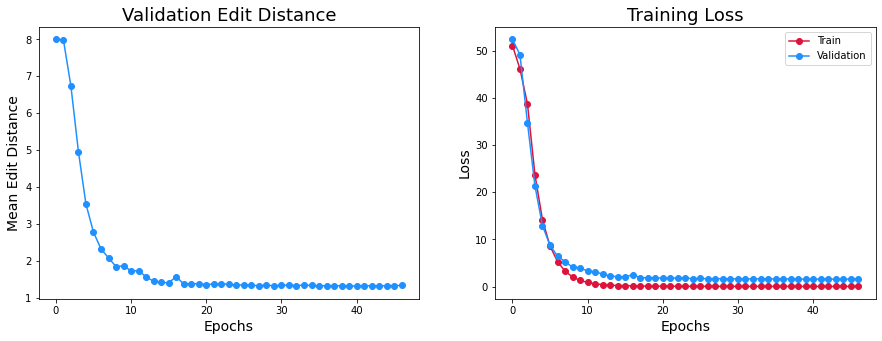

In [27]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_edist_log[best_fold_epoch]}')
plot_training_results(best_history, best_edist_log, 'JustFeaturesInput.png')
best_model.save('JustFeaturesInput.h5')

# Inference

In [28]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [29]:
reloaded_model = load_model('JustFeaturesInput.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_9"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

                                                                    'label_length[0][0]',           
                                                                    'rnn_output[0][0]']             
                                                                                                    
Total params: 15,368,849
Trainable params: 15,364,369
Non-trainable params: 4,480
____________________________________________________________________________________________________


## On test dataset

Batch 1: ['𡛔辰節行\U000f047c句捞𨉓', '達𠸜\U000f047c陸雲仙', '\U000f094e𤳆𥪝𡎝𠊛些', '尊師欺意論盘', '柴朱𠀧道符神\U000f0761蹺', '𠄩\U000f047c\U000f124e泊𠀧\U000f047c才踈', '雖浪㵢泣尼匕', '𡢐昆拱𤎜𭛣𠁀', '民浪小子\U000f047c昆', '吀柴𡮇㐌仕𢭂𠬠𢈱', '碎吀𦋦飭英豪', '雲仙𨅸吏边塘', '小姐昆𡛔茄埃', '爫昆兜敢改吒', '嗔朱賤妾𥛉耒仕分', '𧵑錢\U000f0778固泊鐄拱空']

Batch 2: ['哙戈𠸜户𠬠欺朱詳', '𦖻𦖑㗂呐請台', '嗔迻𠬠物底扲爫信', '月娥應㗂吀侯', '詩耒尼妾吀𤼸', '仰𬂙量𢌌文人\U000f086b芇', '\U000f0778畨宋玉拱\U000f07f4西詩', '如𡆫埃易收埃', '云仙和吏𠬠排𢭂𦋦', '𣈗芇香焒功恩朱払', '畧𡢐\U000f086b拱庒迡', '𮎦䧺吏﨤𮎦雄𠬠欺', '𡦂浪胡越一家', '芇咍𡦂壻鄧連𡦂佳', '武公産達𠬠瓢𨢇唁', '𦰟畑鄧𤏣畧挑罷𠇮']

Batch 3: ['直浪仙本高才', '𠬠𠊛扵府潘章', '調𠓨𠬠舘盃唭語迎', '歆浪渚別湿高', '\U000f0778咍翁舘唭之', '䀡耒吏遣𢚸恒㤕車', '被𡗶欧𠲝𧗱茄𠰺民', '傷民牢庒立身', '拠嘹弹𢭮𦖻𬌥', '欺棋欺𨢇欺琴欺詩', '科尼仙乙𢧚功', '𨉓沙𠖈坦𠬠徐𠻨𠽐', '𡗶牢女負仍才𠊚𣦍', '拠蹺冲礼文公麻爫', '舘浪𡗶坦清明', '𠬠彙巾泊油匕呵傷']



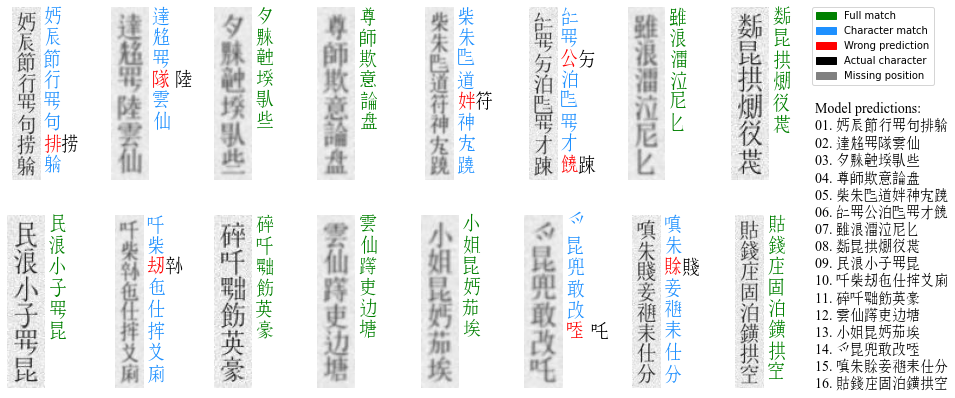

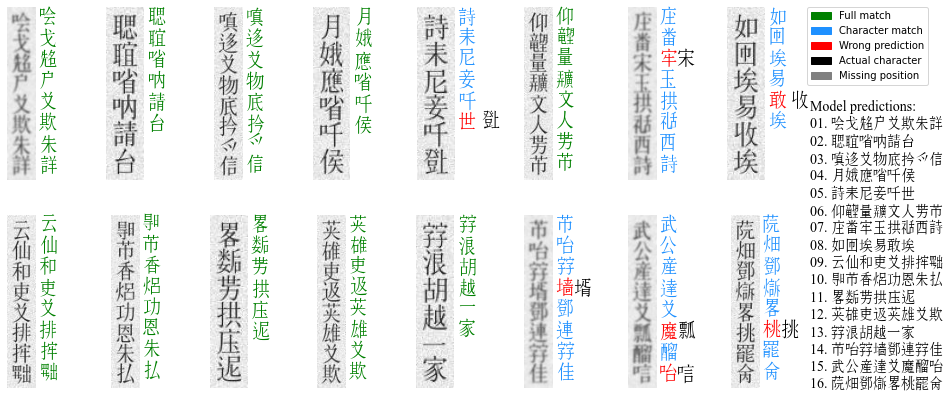

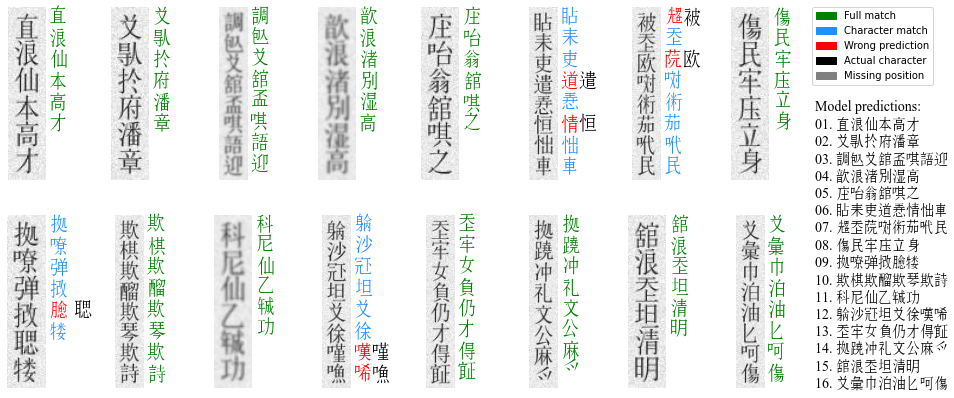

In [30]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [31]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記全書


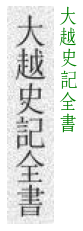

In [32]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))